In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# `PROBLEM STATEMENT`

This is Classification with Localization problem and i will use portion of CALTECH dataset

# `STEP 0: IMPORTING CORE LIBRARIES`

In [2]:
%cd '/kaggle/input/helper-v2'
import gc

import my_helper_funcs as myhf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
# from google.colab.patches import cv2_imshow

/kaggle/input/helper-v2


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# `STEP 1: IMPORTING DATA & get intuition about dataset`


In [3]:
photos_dir = '/kaggle/input/caltech-102/caltech-101/101_ObjectCategories/101_ObjectCategories'
annots_dir = '/kaggle/input/caltech-102/caltech-101/Annotations/Annotations'
labels_dir = '/kaggle/working/' 

In [4]:
img_dir = photos_dir
annot_dir = annots_dir
ifolders = ['airplanes', 'Faces', 'Motorbikes']
afolders = ['Airplanes_Side_2', 'Faces_2', 'Motorbikes_16']
labels_dist = labels_dir + '/labels.csv'
is_first = True

# incase error no dir check is_first
df_annot = myhf.dir_to_df(img_dir, annot_dir, ifolders, afolders, labels_dist, is_first)
df_annot.to_csv(labels_dist, index=False)


In [5]:
df_annot = pd.read_csv(labels_dir + '/labels.csv')
df_annot.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,airplanes/image_0001.jpg,398,164,airplanes,49,30,349,137
1,airplanes/image_0002.jpg,401,184,airplanes,59,35,342,153
2,airplanes/image_0003.jpg,393,165,airplanes,47,36,331,135
3,airplanes/image_0004.jpg,393,170,airplanes,47,24,342,141
4,airplanes/image_0005.jpg,395,176,airplanes,48,18,339,146


In [6]:
indx = df_annot[df_annot['ymin'] >= df_annot['ymax']].index.values
df_annot.drop(index=indx, inplace=True)
print(str(np.count_nonzero(indx)) + " Found")

1 Found


# `STEP 2: VISUALIZING DATASET`

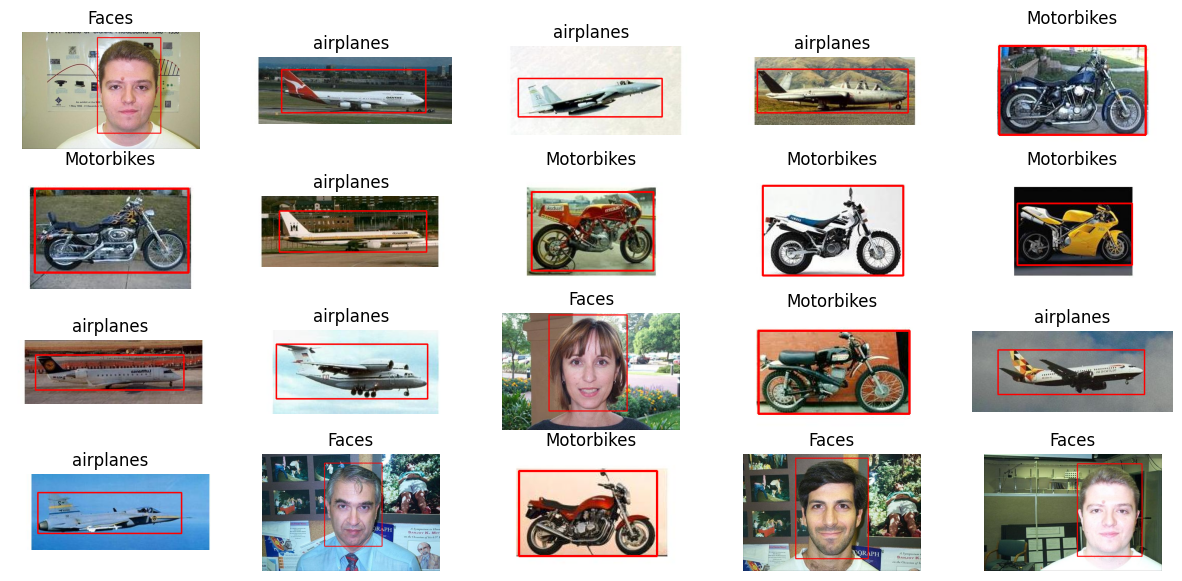

In [7]:
n = 4
m = 5
fig, axs = plt.subplots(n,m, figsize=(15,7))
axs = axs.ravel()
portion = df_annot.sample(n*m, replace=False)
for i in range(len(axs)):
    myhf.show_one(axs[i], portion.iloc[i], 
             dataset_path=photos_dir)

# `STEP 3: PREPROCESSING DATA`
- Resize
- Normlize
- LabelEncode

- ### RESIZE ORIGINAL DATASET

In [8]:
import albumentations as A

resize_pip = A.Compose([A.Resize(300,300,p=1)], bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))
df_resized_annot = myhf.apply_agu_all(df_annot, resize_pip, save_dir=labels_dir, data_path=photos_dir, folder_name='Resized')

df_resized_annot.to_csv(labels_dir + '/resized_labels.csv', index=False)

In [9]:
df_resized_annot = pd.read_csv(labels_dir + '/resized_labels.csv')
df_resized_annot.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,airplanes/resized_0001.jpg,300,300,airplanes,36,54,263,250
1,airplanes/resized_0002.jpg,300,300,airplanes,44,57,255,249
2,airplanes/resized_0003.jpg,300,300,airplanes,35,65,252,245
3,airplanes/resized_0004.jpg,300,300,airplanes,35,42,261,248
4,airplanes/resized_0005.jpg,300,300,airplanes,36,30,257,248


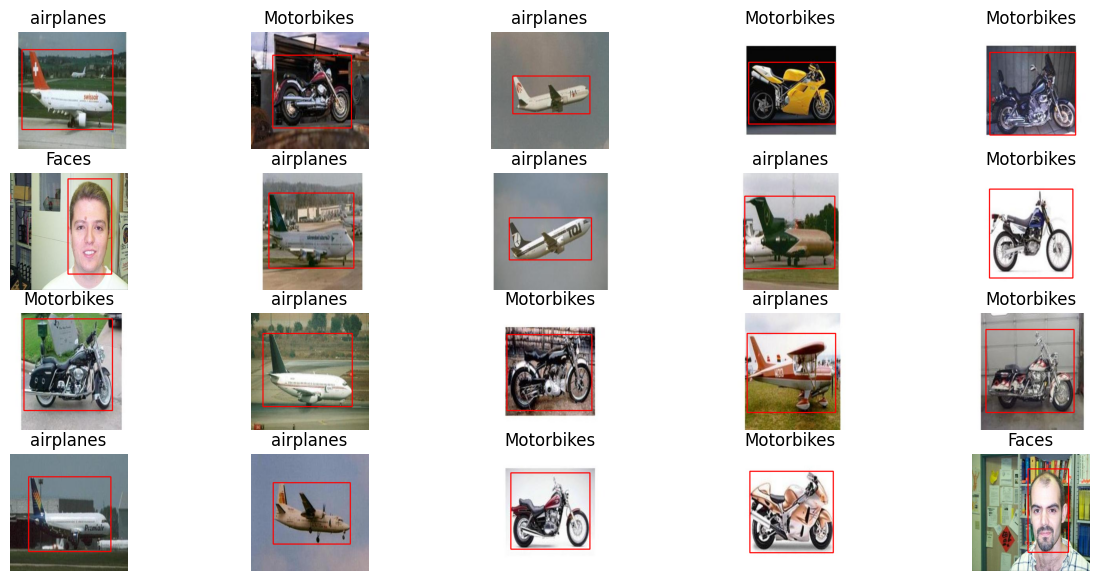

In [10]:
n = 4
m = 5
fig, axs = plt.subplots(n,m, figsize=(15,7))
axs = axs.ravel()
portion = df_resized_annot.sample(n*m, replace=False)
for i in range(len(axs)):
    myhf.show_one(axs[i], portion.iloc[i], 
             dataset_path=labels_dir + '/Resized')

- ### LOAD DATASET
- I did also:
    - Normalization
    - LabelEncoding


In [11]:
dataset_dir = labels_dir + '/Resized'
images, cat_labels, bboxes = myhf.load_dataset_and_bboxes(df_resized_annot, dataset_dir, normalize=True)

In [12]:
del df_resized_annot, dataset_dir

In [13]:
ohe = OneHotEncoder(categories=[['airplanes', 'Faces', 'Motorbikes']], sparse_output=False)
ohe_labels = ohe.fit_transform(np.array(cat_labels).reshape(-1,1))

In [14]:
del cat_labels

# `STEP 4: SPLIT DATA`

In [15]:
x_train, x_val, labels_train, labels_val, bbox_train, bbox_val = train_test_split(images, 
                ohe_labels, bboxes, test_size = 0.1, random_state = 43)

In [16]:
del images
del ohe_labels
del bboxes

In [17]:
x_train.shape, x_val.shape, labels_train.shape, labels_val.shape, bbox_train.shape, bbox_val.shape

((1828, 300, 300, 3),
 (204, 300, 300, 3),
 (1828, 3),
 (204, 3),
 (1828, 4),
 (204, 4))

# `STEP 5: MODELS TRAINING Without AGUMENTATION`

## NASNET as base model

In [18]:
from keras.applications import NASNetMobile
N_model = NASNetMobile(input_shape=(300,300,3), include_top=False, weights='imagenet')
N_model.trainable = False

19993432/19993432 [==============================] - 1s 0us/step


In [19]:
num_classes = 3

# x_input = InputLayer(input_shape=(300,300,3), name='I')
model_out = N_model(N_model.input, training=False)
x = GlobalAveragePooling2D()(model_out)
x = Flatten()(x)

bboxHead = Dense(256, activation="relu")(x)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dropout(0.2)(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dropout(0.2)(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation='relu', name= "bbox")(bboxHead)

classHead = Dense(256, activation="relu")(x)
classHead = Dense(128, activation="relu")(classHead)
classHead = Dropout(0.2)(classHead)
classHead = Dense(64, activation="relu")(classHead)
classHead = Dropout(0.2)(classHead)
classHead = Dense(32, activation="relu")(classHead)
classHead = Dense(num_classes, activation='softmax',name="class")(classHead)

nasnet_model = tf.keras.models.Model(inputs=N_model.input, outputs=(bboxHead, classHead))

In [20]:
nasnet_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss={ 
    "bbox": "mean_squared_error",
    "class": "categorical_crossentropy"
    },
  metrics={'class': 'accuracy'})

In [21]:
trainTargets = {"class": labels_train,
                "bbox": bbox_train}

testTargets = {"class": labels_val,
                "bbox": bbox_val}

H_nas = nasnet_model.fit(
    x_train, trainTargets,
    validation_data=(x_val, testTargets),
    batch_size=32, epochs=20 ,verbose=1)

Epoch 1/20
58/58 [==============================] - 35s 217ms/step - loss: 31812.6797 - bbox_loss: 31811.9785 - class_loss: 0.7093 - class_accuracy: 0.7681 - val_loss: 29260.0859 - val_bbox_loss: 29259.8730 - val_class_loss: 0.2164 - val_class_accuracy: 1.0000
Epoch 2/20
58/58 [==============================] - 7s 123ms/step - loss: 22727.9199 - bbox_loss: 22727.7930 - class_loss: 0.1337 - class_accuracy: 0.9912 - val_loss: 12094.7686 - val_bbox_loss: 12094.7529 - val_class_loss: 0.0170 - val_class_accuracy: 1.0000
Epoch 3/20
58/58 [==============================] - 7s 119ms/step - loss: 5458.6777 - bbox_loss: 5458.6416 - class_loss: 0.0336 - class_accuracy: 0.9973 - val_loss: 2418.6316 - val_bbox_loss: 2418.6260 - val_class_loss: 0.0056 - val_class_accuracy: 1.0000
Epoch 4/20
58/58 [==============================] - 8s 130ms/step - loss: 2574.7678 - bbox_loss: 2574.7539 - class_loss: 0.0133 - class_accuracy: 0.9989 - val_loss: 1882.3905 - val_bbox_loss: 1882.3878 - val_class_loss: 0.0

In [22]:
nasnet_model.save('/kaggle/working/NasNet_20eb.h5', save_format="h5")
pd.DataFrame(H_nas.history).to_csv('/kaggle/working/Hist_nas_20eb.csv', index=False)

In [23]:
H_nas.history.keys()

dict_keys(['loss', 'bbox_loss', 'class_loss', 'class_accuracy', 'val_loss', 'val_bbox_loss', 'val_class_loss', 'val_class_accuracy'])

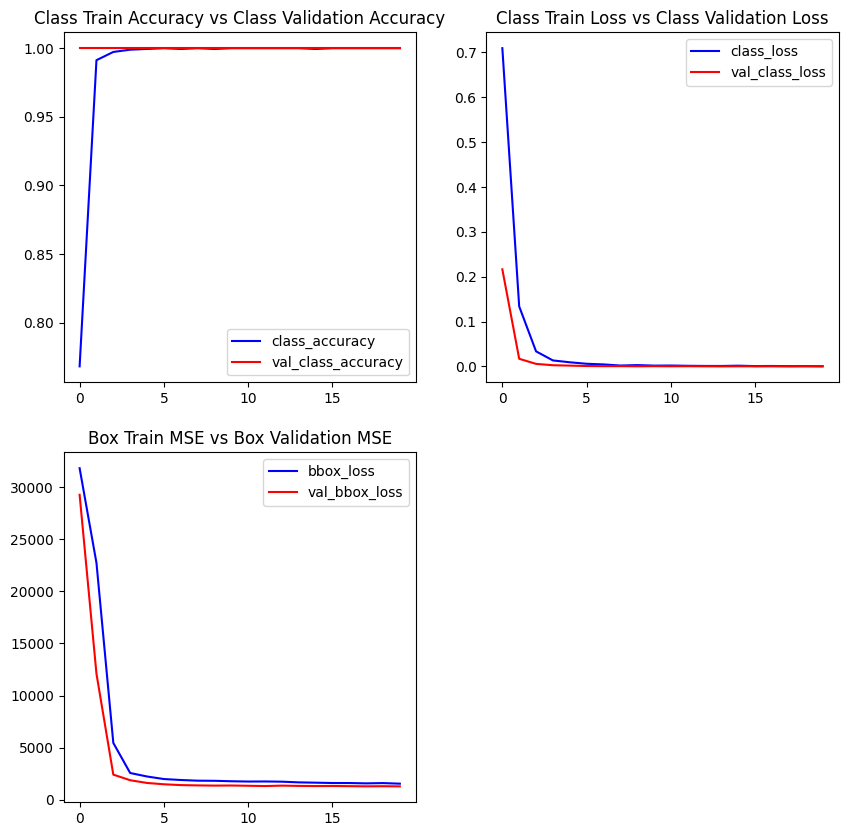

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
myhf.plot(H_nas, 'class_accuracy', 'val_class_accuracy', 'Class Train Accuracy vs Class Validation Accuracy')

plt.subplot(2,2,2)
myhf.plot(H_nas, 'class_loss', 'val_class_loss', 'Class Train Loss vs Class Validation Loss')

plt.subplot(2,2,3)
myhf.plot(H_nas, 'bbox_loss', 'val_bbox_loss', 'Box Train MSE vs Box Validation MSE')

## VGG16 as base model

In [25]:
from keras.applications import VGG16
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(300, 300, 3))
vgg.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [26]:
x = vgg.output
x = Flatten()(x)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(x)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="relu", name="bbox")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
classHead = Dense(512, activation="relu")(x)
classHead = Dropout(0.5)(classHead)
classHead = Dense(512, activation="relu")(classHead)
classHead = Dropout(0.5)(classHead)
classHead = Dense(3, activation="softmax", name="class")(classHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
vggnet_model = tf.keras.models.Model(inputs=vgg.input, outputs=(bboxHead, classHead))

In [27]:
losses = {"class": "categorical_crossentropy",
          "bbox": "mean_squared_error",}

lossWeights = {"class": 1.0,
               "bbox": 1.0}

vggnet_model.compile(loss=losses, optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics={'class': 'accuracy'},
              loss_weights=lossWeights)

In [28]:
trainTargets = {"class": labels_train,
                "bbox": bbox_train}

testTargets = {"class": labels_val,
               "bbox": bbox_val}

H_vgg = vggnet_model.fit(
    x_train, trainTargets,
    validation_data=(x_val, testTargets),
    batch_size=32, epochs=20, verbose=1)

Epoch 1/20
58/58 [==============================] - 19s 197ms/step - loss: 6436.3262 - bbox_loss: 6435.7192 - class_loss: 0.6069 - class_accuracy: 0.9212 - val_loss: 1190.2783 - val_bbox_loss: 1190.2783 - val_class_loss: 1.1103e-08 - val_class_accuracy: 1.0000
Epoch 2/20
58/58 [==============================] - 8s 140ms/step - loss: 1380.9600 - bbox_loss: 1380.9498 - class_loss: 0.0101 - class_accuracy: 0.9984 - val_loss: 1017.1695 - val_bbox_loss: 1017.1695 - val_class_loss: 1.1687e-09 - val_class_accuracy: 1.0000
Epoch 3/20
58/58 [==============================] - 9s 151ms/step - loss: 887.6383 - bbox_loss: 887.5985 - class_loss: 0.0397 - class_accuracy: 0.9973 - val_loss: 928.5712 - val_bbox_loss: 928.5712 - val_class_loss: 7.3045e-08 - val_class_accuracy: 1.0000
Epoch 4/20
58/58 [==============================] - 8s 140ms/step - loss: 877.7512 - bbox_loss: 877.6506 - class_loss: 0.1006 - class_accuracy: 0.9885 - val_loss: 973.1100 - val_bbox_loss: 973.1100 - val_class_loss: 1.1145e

In [29]:
vggnet_model.save('/kaggle/working/vgg_20eb.h5')
pd.DataFrame(H_vgg.history).to_csv('/kaggle/working/Hist_vgg_20eb.csv', index=False)

In [30]:
H_vgg.history.keys()

dict_keys(['loss', 'bbox_loss', 'class_loss', 'class_accuracy', 'val_loss', 'val_bbox_loss', 'val_class_loss', 'val_class_accuracy'])

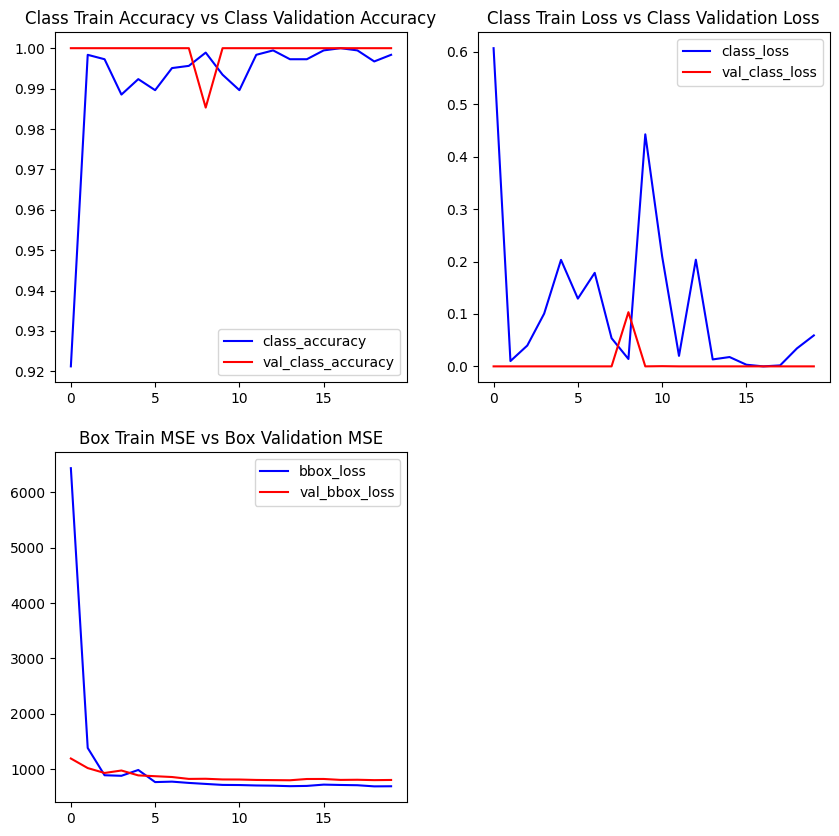

In [31]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
myhf.plot(H_vgg, 'class_accuracy', 'val_class_accuracy', 'Class Train Accuracy vs Class Validation Accuracy')

plt.subplot(2,2,2)
myhf.plot(H_vgg, 'class_loss', 'val_class_loss', 'Class Train Loss vs Class Validation Loss')

plt.subplot(2,2,3)
myhf.plot(H_vgg, 'bbox_loss', 'val_bbox_loss', 'Box Train MSE vs Box Validation MSE')

# `STEP 6: MODELS Evaluation`

In [32]:
loaded_nasnet = nasnet_model

In [33]:
yy = np.random.randint(0,204)
y_bbox_hat, y_class_hat = loaded_nasnet.predict(np.expand_dims(x_val[yy], axis=0))
y_bbox_hat, y_class_hat

1/1 [==============================] - 4s 4s/step


(array([[  0.      ,  40.342808, 266.30557 , 272.27148 ]], dtype=float32),
 array([[1.4766056e-06, 9.9999845e-01, 6.1118783e-08]], dtype=float32))

In [34]:
labels_val[yy], bbox_val[yy]


(array([0., 1., 0.]), array([ 35,  19, 165, 264]))

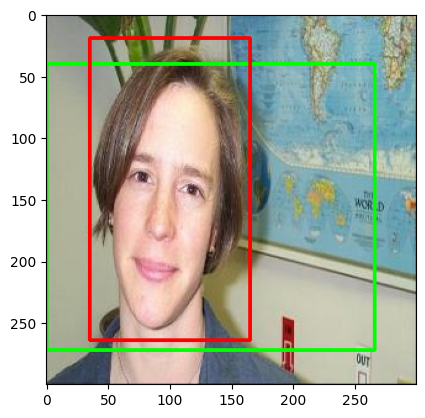

In [35]:
import cv2
ing = cv2.rectangle(x_val[yy], (int(y_bbox_hat[0][0]),int(y_bbox_hat[0][1])), (int(y_bbox_hat[0][2]),int(y_bbox_hat[0][3])), (0,255,0),2)
ing = cv2.rectangle(ing, (int(bbox_val[yy][0]),int(bbox_val[yy][1])), (int(bbox_val[yy][2]),int(bbox_val[yy][3])),(255,0,0), 2)
plt.imshow(ing)